# 05. Plots

✅ Matrizes de Confusão geradas e salvas em: ../reports/figures/matrizes_confusao_comparativo.png


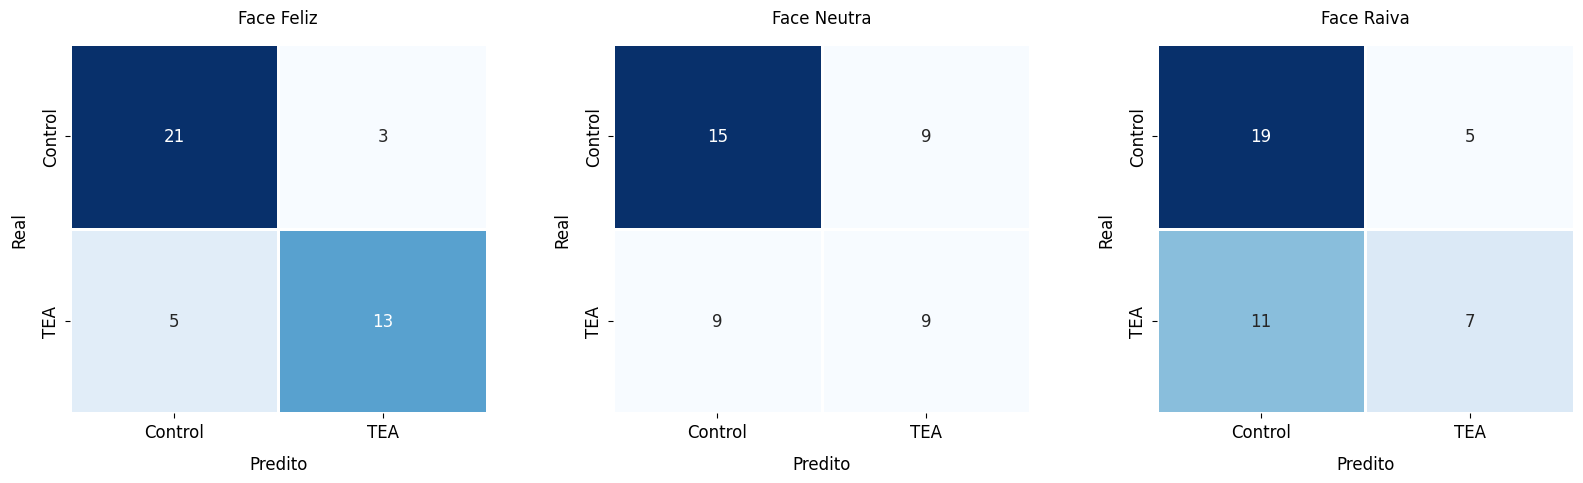

In [18]:
# 01. VISUALIZAÇÃO: MATRIZES DE CONFUSÃO (COMPARATIVO)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import LeaveOneOut, cross_val_predict
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
import warnings
import os

warnings.filterwarnings("ignore")

# 1. Configurações Visuais (Estritas: Tamanho 12, Sem Negrito)
plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 12,
    'axes.labelsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'font.weight': 'normal',
    'axes.labelweight': 'normal',
    'axes.titleweight': 'normal'
})

# 2. Carregamento de Dados
caminho_csv = '../reports/tabela_features_eeg_completa.csv'
df = pd.read_csv(caminho_csv)

# Lendo os nomes exatos que o extrator padronizado gerou
condicoes_busca = {
    'Face Feliz': ['Face Feliz'],
    'Face Neutra': ['Face Neutra'],
    'Face Raiva': ['Face Raiva']
}

paletas = ['Blues', 'Blues', 'Blues']

# 3. Pipeline Campeão (XGBoost + k=15)
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', RobustScaler()),
    ('selector', SelectKBest(score_func=f_classif, k=15)),
    ('clf', XGBClassifier(n_estimators=100, max_depth=3, learning_rate=0.1, 
                          eval_metric='logloss', random_state=97))
])

# 4. Preparação do Plot (1 linha, 3 colunas)
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
fig.patch.set_facecolor('white')

for idx, (nome_condicao, lista_triggers) in enumerate(condicoes_busca.items()):
    df_f = df[df['Condicao'].isin(lista_triggers)].copy()
    
    if df_f.empty:
        axes[idx].set_title(f"{nome_condicao}\n(Sem dados)")
        axes[idx].axis('off')
        continue

    # Garantia do N=42
    df_f = df_f.groupby(['ID', 'Grupo']).mean(numeric_only=True).reset_index()
    y = df_f['Grupo'].apply(lambda x: 1 if 'TEA' in x else 0).values
    X = df_f.drop(columns=['ID', 'Grupo', 'Condicao', 'Tipo'], errors='ignore')

    # Predição com LOOCV
    y_pred = cross_val_predict(pipeline, X, y, cv=cv_strategy)
    cm = confusion_matrix(y, y_pred)

    # Plotagem Individual
    sns.heatmap(cm, annot=True, fmt='d', cmap=paletas[idx], cbar=False, ax=axes[idx],
                xticklabels=['Control', 'TEA'], yticklabels=['Control', 'TEA'],
                annot_kws={"size": 12, "weight": "normal"}, 
                linewidths=2, linecolor='white')
    
    axes[idx].set_title(nome_condicao, pad=15)
    axes[idx].set_ylabel('Real', labelpad=10)
    axes[idx].set_xlabel('Predito', labelpad=10)

plt.tight_layout(w_pad=4.0)

os.makedirs('../reports/figures', exist_ok=True)
caminho_imagem = '../reports/figures/matrizes_confusao_comparativo.png'
plt.savefig(caminho_imagem, dpi=300, bbox_inches='tight')
print(f"✅ Matrizes de Confusão geradas e salvas em: {caminho_imagem}")
plt.show()

⏳ Executando o Benchmark dos Modelos (LOOCV)...
✅ Gráfico gerado! Salvo em: ../reports/figures/fig02_comparativo_modelos.png


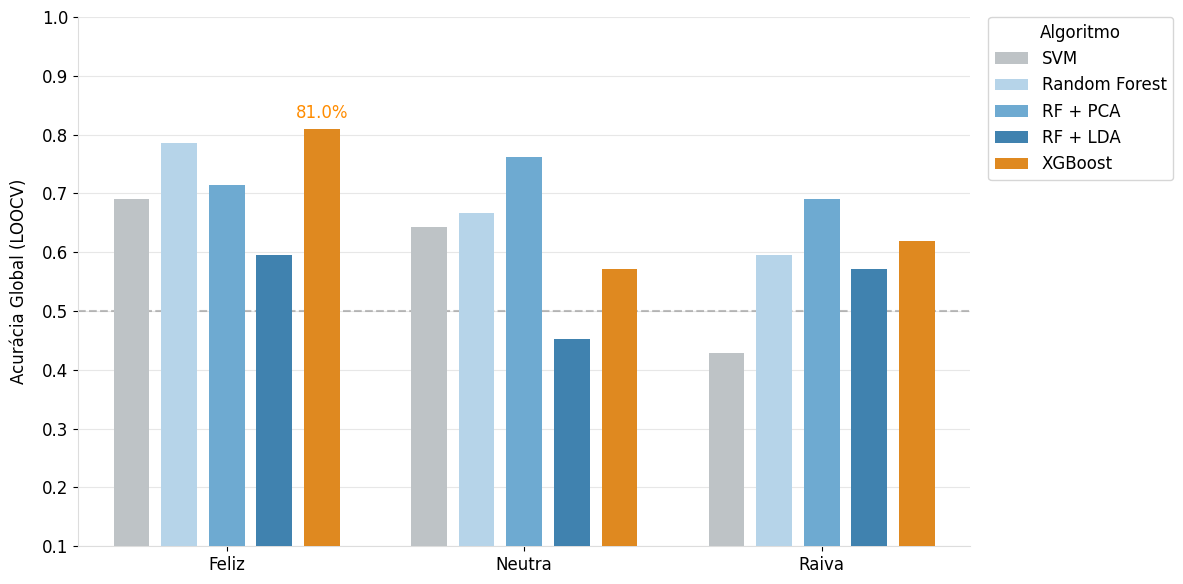

In [2]:
# 02. VISUALIZAÇÃO: BENCHMARK DE ALGORITMOS

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import LeaveOneOut, cross_val_score
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
import warnings
import os

warnings.filterwarnings("ignore")

print("⏳ Executando o Benchmark dos Modelos (LOOCV)...")

# 1. Configurações Visuais (Estritas: Tamanho 12, Sem Negrito, Fundo Limpo)
plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 12,
    'axes.labelsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'font.weight': 'normal',
    'axes.labelweight': 'normal',
    'axes.titleweight': 'normal',
    'figure.facecolor': 'white',
    'axes.facecolor': 'white'
})

# 2. Carregamento dos Dados
caminho_csv = '../reports/tabela_features_eeg_completa.csv'
df = pd.read_csv(caminho_csv)

condicoes_busca = {
    'Feliz': ['Face Feliz'],
    'Neutra': ['Face Neutra'],
    'Raiva': ['Face Raiva']
}

SEED = 97
cv_strategy = LeaveOneOut()

# 3. Definição dos Pipelines
modelos = {
    'SVM': Pipeline([('i', SimpleImputer()), ('s', RobustScaler()), ('sel', SelectKBest(f_classif, k=15)), 
                     ('clf', SVC(kernel='linear', random_state=SEED))]),
    
    'Random Forest': Pipeline([('i', SimpleImputer()), ('s', RobustScaler()), ('sel', SelectKBest(f_classif, k=15)), 
                               ('clf', RandomForestClassifier(n_estimators=100, max_depth=3, random_state=SEED))]),
    
    'RF + PCA': Pipeline([('i', SimpleImputer()), ('s', RobustScaler()), ('pca', PCA(n_components=10, random_state=SEED)), 
                          ('clf', RandomForestClassifier(n_estimators=100, max_depth=3, random_state=SEED))]),
    
    'RF + LDA': Pipeline([('i', SimpleImputer()), ('s', RobustScaler()), ('lda', LDA()), 
                          ('clf', RandomForestClassifier(n_estimators=100, max_depth=3, random_state=SEED))]),
    
    'XGBoost': Pipeline([('i', SimpleImputer()), ('s', RobustScaler()), ('sel', SelectKBest(f_classif, k=15)), 
                         ('clf', XGBClassifier(n_estimators=100, max_depth=3, learning_rate=0.1, eval_metric='logloss', random_state=SEED))])
}

# 4. Extração de Resultados
resultados = []

for nome_condicao, lista_triggers in condicoes_busca.items():
    df_f = df[df['Condicao'].isin(lista_triggers)].copy()
    if df_f.empty: continue
        
    df_f = df_f.groupby(['ID', 'Grupo']).mean(numeric_only=True).reset_index()
    y = df_f['Grupo'].apply(lambda x: 1 if 'TEA' in x else 0).values
    X = df_f.drop(columns=['ID', 'Grupo', 'Condicao', 'Tipo'], errors='ignore')
    
    for nome_modelo, pipeline in modelos.items():
        acc = cross_val_score(pipeline, X, y, cv=cv_strategy).mean()
        resultados.append({'Condição': nome_condicao, 'Algoritmo': nome_modelo, 'Acurácia': acc})

df_resultados = pd.DataFrame(resultados)

# 5. Plotagem Gráfica Profissional
fig, ax = plt.subplots(figsize=(12, 6))

# Força a grade a ficar atrás das barras
ax.set_axisbelow(True)

# Cores personalizadas | SVM (Cinza), RF (Azul Claro), RF+PCA (Azul Médio), RF+LDA (Azul Escuro), XGBoost (Laranja)
cores_personalizadas = ['#BDC3C7', '#AED6F1', '#5DADE2', '#2E86C1', '#FF8C00']

# zorder=3 garante que as barras fiquem na camada da frente
sns.barplot(data=df_resultados, x='Condição', y='Acurácia', hue='Algoritmo', 
            palette=cores_personalizadas, edgecolor='none', ax=ax, zorder=3)

# A função de afinar as barras
def change_width(ax, new_value):
    for patch in ax.patches:
        current_width = patch.get_width()
        diff = current_width - new_value
        patch.set_width(new_value)
        patch.set_x(patch.get_x() + diff * .5)

change_width(ax, 0.12)

# Linha de chance a 50% desenhada na camada do meio (zorder=2)
ax.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5, zorder=2)

ax.set_ylim(0.1, 1.0)
ax.set_ylabel('Acurácia Global (LOOCV)', labelpad=10)
ax.set_xlabel('')

# Grade sutil desenhada na camada do fundo (zorder=1)
ax.grid(axis='y', linestyle='-', alpha=0.3, color='#B0B0B0', zorder=1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('#DDDDDD')
ax.spines['bottom'].set_color('#DDDDDD')

plt.legend(title='Algoritmo', bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)

# Destacar a barra campeã com fonte 12
max_acc = df_resultados['Acurácia'].max()
for p in ax.patches:
    altura = p.get_height()
    if abs(altura - max_acc) < 0.001:
        ax.annotate(f'{altura:.1%}', 
                    (p.get_x() + p.get_width() / 2., altura), 
                    ha='center', va='bottom', 
                    xytext=(0, 5), textcoords='offset points', 
                    color='#FF8C00', fontsize=12, fontweight='normal')

plt.tight_layout()

# 6. Salvamento
os.makedirs('../reports/figures', exist_ok=True)
caminho_imagem = '../reports/figures/fig02_comparativo_modelos.png'
plt.savefig(caminho_imagem, dpi=300, bbox_inches='tight')

print(f"✅ Gráfico gerado! Salvo em: {caminho_imagem}")
plt.show()

⏳ Extraindo as regras biológicas do Random Forest para as 3 condições...

------------------------------------------------------------
 PROCESSANDO: FACE FELIZ
------------------------------------------------------------


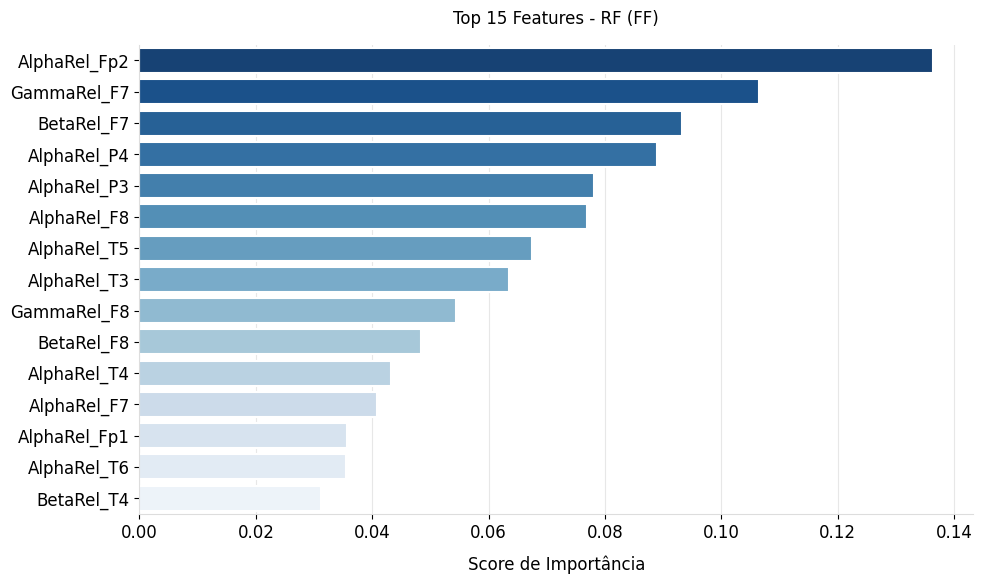

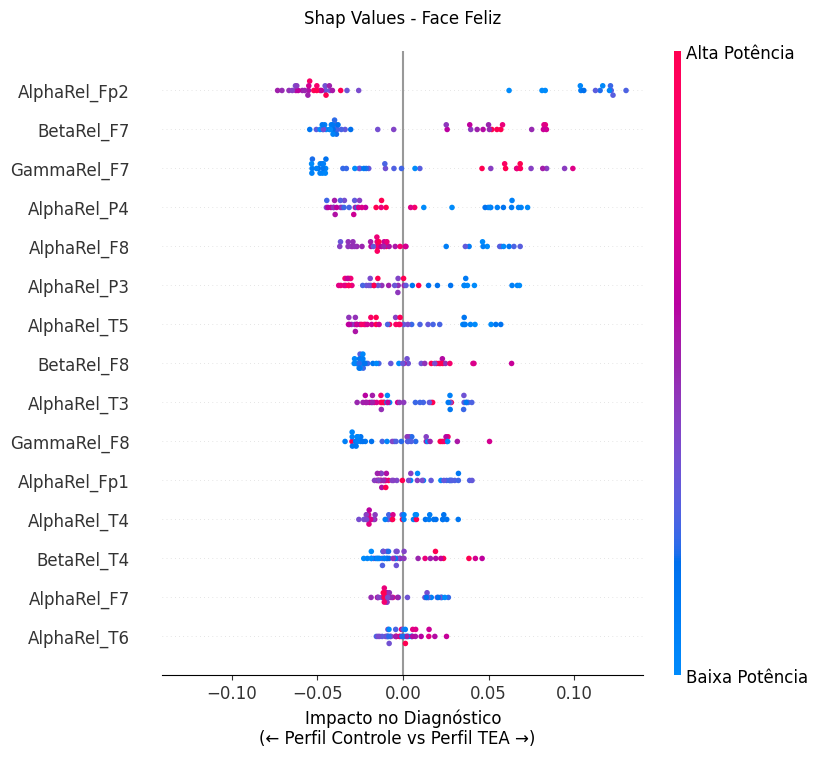


------------------------------------------------------------
 PROCESSANDO: FACE NEUTRA
------------------------------------------------------------


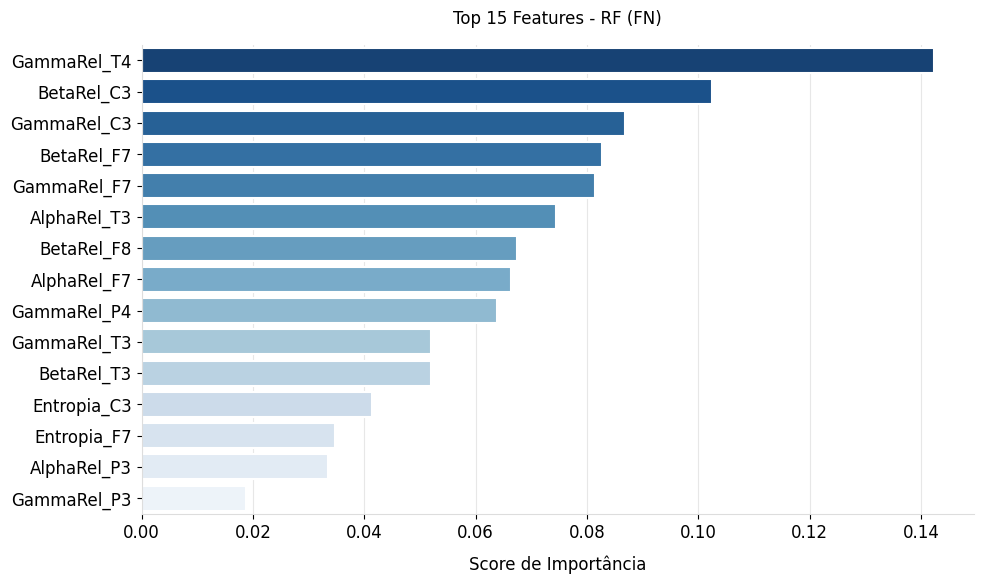

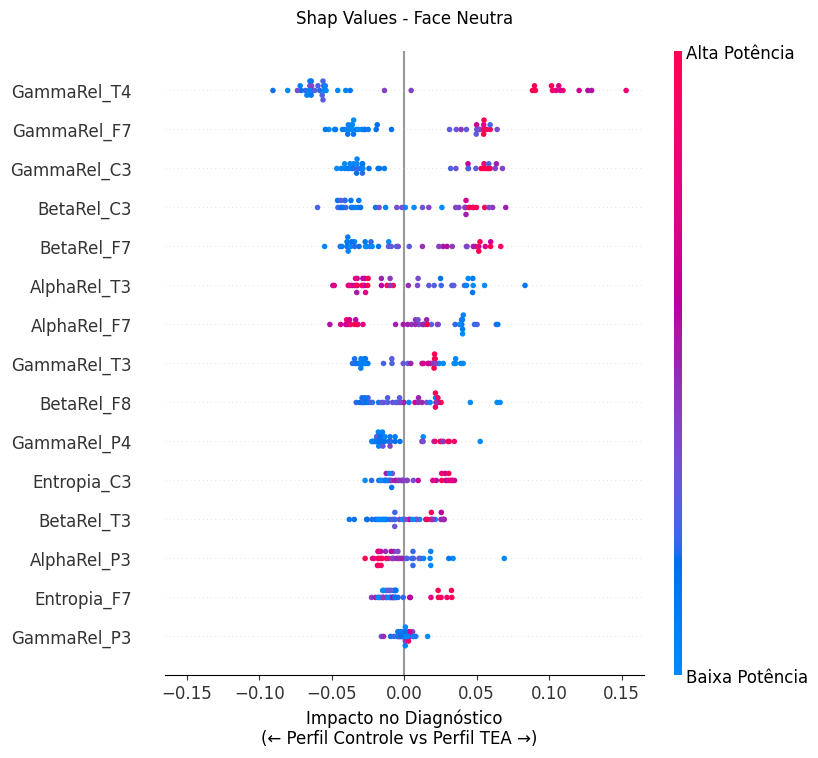


------------------------------------------------------------
 PROCESSANDO: FACE RAIVA
------------------------------------------------------------


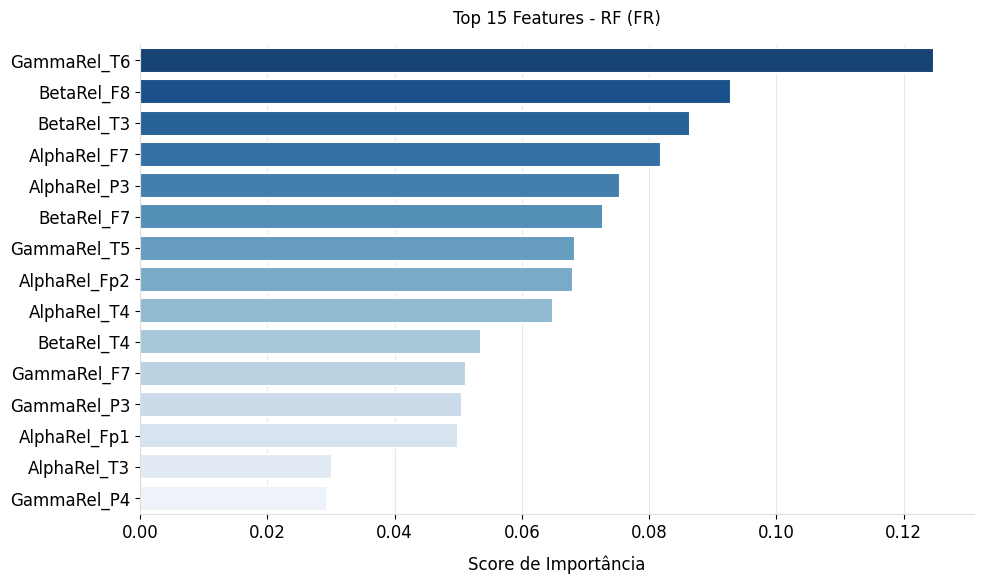

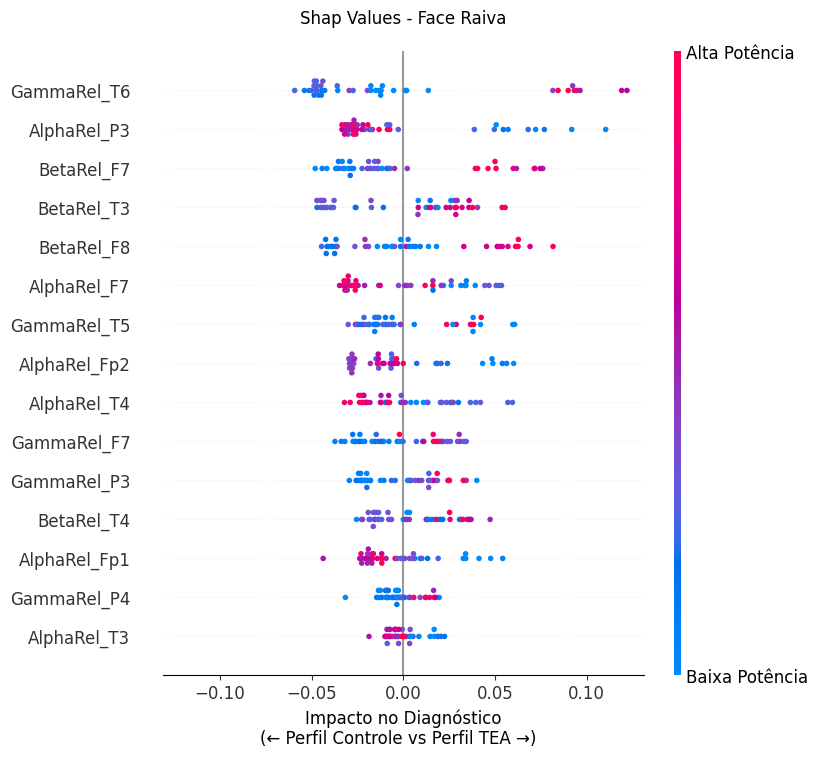


✅ Todas as imagens foram processadas.


In [14]:
# 03. VISUALIZAÇÃO: FEATURE IMPORTANCE E SHAP VALUES 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
import os
import warnings

try:
    import shap
except ImportError:
    print("⚠️ A biblioteca 'shap' não está instalada. Execute '!pip install shap' e rode novamente.")
    shap = None

warnings.filterwarnings("ignore")

print("⏳ Extraindo as regras biológicas do Random Forest para as 3 condições...")

# 1. Configurações Visuais Estritas (Tamanho 12, Sem Negrito)
plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 12,
    'axes.labelsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'font.weight': 'normal',
    'axes.labelweight': 'normal',
    'axes.titleweight': 'normal',
    'figure.facecolor': 'white',
    'axes.facecolor': 'white'
})

caminho_csv = '../reports/tabela_features_eeg_completa.csv'
df = pd.read_csv(caminho_csv)

# Dicionário com os nomes das condições e suas siglas para o título
condicoes = {
    'Face Feliz': 'FF',
    'Face Neutra': 'FN',
    'Face Raiva': 'FR'
}

SEED = 97

for nome_condicao, sigla in condicoes.items():
    print(f"\n" + "-"*60)
    print(f" PROCESSANDO: {nome_condicao.upper()}")
    print("-"*60)
    
    df_f = df[df['Condicao'] == nome_condicao].copy()
    if df_f.empty:
        print(f"Atenção: Sem dados para {nome_condicao}. Pulando...")
        continue
        
    df_f = df_f.groupby(['ID', 'Grupo']).mean(numeric_only=True).reset_index()
    
    y = df_f['Grupo'].apply(lambda x: 1 if 'TEA' in x else 0).values
    X_bruto = df_f.drop(columns=['ID', 'Grupo', 'Condicao', 'Tipo'], errors='ignore')

    # Pipeline
    imputer = SimpleImputer(strategy='mean')
    X_imp = imputer.fit_transform(X_bruto)

    scaler = RobustScaler()
    X_sca = scaler.fit_transform(X_imp)

    selector = SelectKBest(score_func=f_classif, k=15)
    X_sel = selector.fit_transform(X_sca, y)

    indices_selecionados = selector.get_support(indices=True)
    nomes_features = X_bruto.columns[indices_selecionados]

    # Treinamento Global
    rf_modelo = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=SEED)
    rf_modelo.fit(X_sel, y)

    # 1 - FEATURE IMPORTANCE PLOTS
    importancias = rf_modelo.feature_importances_
    df_imp = pd.DataFrame({
        'Variável': nomes_features,
        'Importância': importancias
    }).sort_values(by='Importância', ascending=False)

    fig1, ax1 = plt.subplots(figsize=(10, 6))
    ax1.set_axisbelow(True)

    sns.barplot(data=df_imp, x='Importância', y='Variável', palette='Blues_r', edgecolor='white', linewidth=1.5, ax=ax1)

    # Ajustes de título e legenda
    ax1.set_title(f'Top 15 Features - RF ({sigla})', pad=15)
    ax1.set_xlabel('Score de Importância', labelpad=10)
    ax1.set_ylabel('')

    ax1.grid(axis='x', linestyle='-', alpha=0.3, color='#B0B0B0')
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['left'].set_color('#DDDDDD')
    ax1.spines['bottom'].set_color('#DDDDDD')

    plt.tight_layout()
    os.makedirs('../reports/figures', exist_ok=True)
    caminho_fig3a = f'../reports/figures/fig03_feature_importance_{sigla.lower()}.png'
    plt.savefig(caminho_fig3a, dpi=300, bbox_inches='tight')
    plt.show()

    # 2 - SHAP VALUES
    if shap is not None:
        fig2 = plt.figure(figsize=(10, 6))
        
        explainer = shap.TreeExplainer(rf_modelo)
        shap_values = explainer.shap_values(X_sel)
        
        if isinstance(shap_values, list):
            shap_values_tea = shap_values[1]
        elif len(shap_values.shape) == 3:
            shap_values_tea = shap_values[:, :, 1]
        else:
            shap_values_tea = shap_values
            
        if shap_values_tea.shape[1] > X_sel.shape[1]:
            shap_values_tea = shap_values_tea[:, :X_sel.shape[1]]
            
        plt.title(f'Shap Values - {nome_condicao}', pad=20, fontsize=12)
        
        shap.summary_plot(shap_values_tea, X_sel, feature_names=list(nomes_features), show=False)
        
        # Centralização do eixo x
        ax2 = plt.gca()
        limites_x = ax2.get_xlim()
        max_abs = max(abs(limites_x[0]), abs(limites_x[1]))
        ax2.set_xlim(-max_abs, max_abs) 
        
        ax2.set_xlabel('Impacto no Diagnóstico\n(← Perfil Controle vs Perfil TEA →)  ', fontsize=12, fontweight='normal')
        ax2.tick_params(axis='both', labelsize=12)
        
        fig = plt.gcf()
        for ax in fig.axes:
            if ax != ax2: 
                ax.set_ylabel('') 
                ax.set_yticks([0, 1])
                ax.set_yticklabels(['Baixa Potência', 'Alta Potência'], fontsize=12, fontweight='normal')
                ax.tick_params(length=0) 
        
        caminho_fig3b = f'../reports/figures/fig04_shap_values_{sigla.lower()}.png'
        plt.savefig(caminho_fig3b, dpi=300, bbox_inches='tight')
        plt.show()

print("\n✅ Todas as imagens foram processadas.")

⏳ Gerando o painel Alpha/Gamma (1x2)...


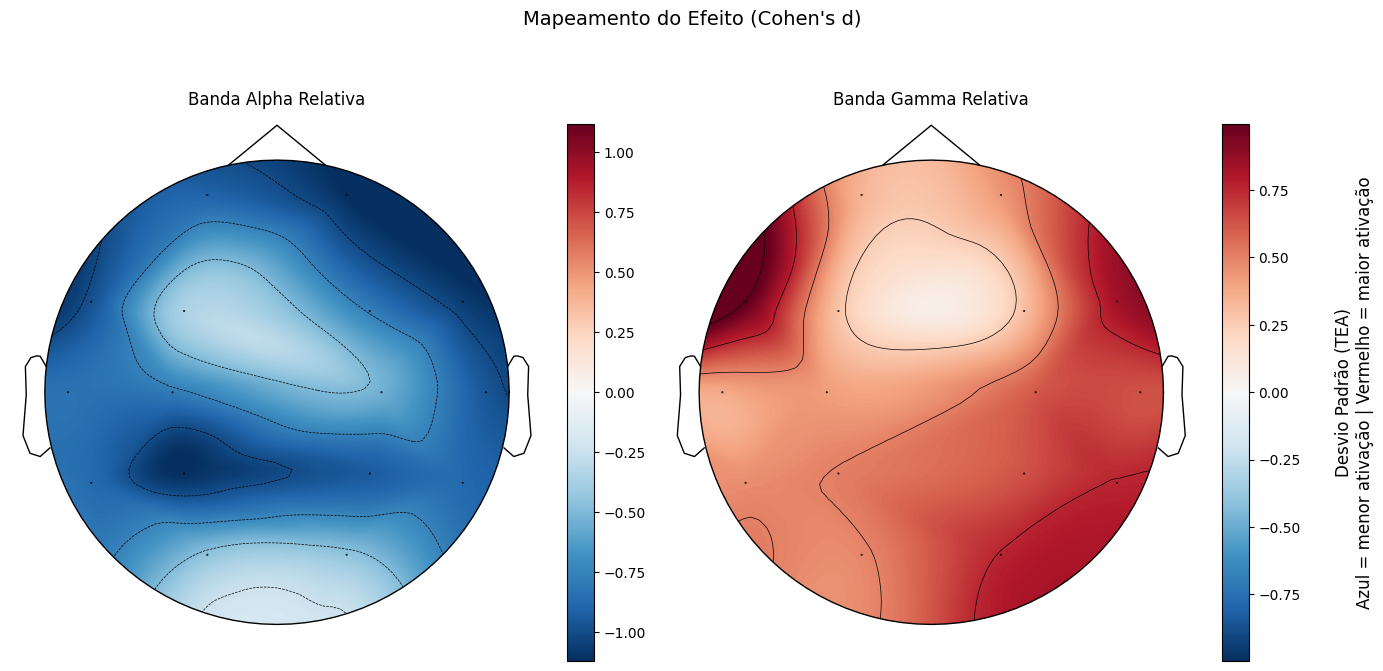

✅ Painel topográfico focado gerado e salvo em: ../reports/figures/fig05_painel_topografico_focado.png


In [15]:
# 04. VISUALIZAÇÃO: MAPA TOPOGRÁFICO DO TAMANHO DE EFEITO (COHEN'S D) - ALPHA E GAMMA

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mne
import os
import warnings

# Configurações de segurança e silenciamento de avisos
warnings.filterwarnings("ignore")
mne.set_log_level('WARNING')

print("⏳ Gerando o painel Alpha/Gamma (1x2)...")

# 1. Configurações Visuais Estritas (Tamanho 12, Sem Negrito)
plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 12,
    'axes.labelsize': 12,
    'font.weight': 'normal',
    'axes.titleweight': 'normal',
    'figure.facecolor': 'white'
})

# 2. Geometria: Posições exatas dos 16 Canais
posicoes_manuais = {
    'Fp1': [-0.30, 0.85], 'Fp2': [ 0.30, 0.85],
    'F7':  [-0.80, 0.39], 'F3':  [-0.40, 0.35], 'F4':  [ 0.40, 0.35], 'F8':  [ 0.80, 0.39],
    'T3':  [-0.90, 0.00], 'C3':  [-0.45, 0.00], 'C4':  [ 0.45, 0.00], 'T4':  [ 0.90, 0.00],
    'T5':  [-0.80, -0.39], 'P3':  [-0.40, -0.35], 'P4':  [ 0.40, -0.35], 'T6':  [ 0.80, -0.39],
    'O1':  [-0.30, -0.70], 'O2':  [ 0.30, -0.70]
}
canais_reais = ['Fp1', 'Fp2', 'F7', 'F3', 'F4', 'F8', 'T3', 'C3', 'C4', 'T4', 'T5', 'P3', 'P4', 'T6', 'O1', 'O2']
pos_array = np.array([posicoes_manuais[ch] for ch in canais_reais])

# 3. Dados: Carregamento e Isolamento da Face Feliz (N=42)
caminho_csv = '../reports/tabela_features_eeg_completa.csv'
df = pd.read_csv(caminho_csv)

# Filtra a condição e garante a média por sujeito (N=42)
df_f = df[df['Condicao'] == 'Face Feliz'].copy()
df_f = df_f.groupby(['ID', 'Grupo']).mean(numeric_only=True).reset_index()

# Define os grupos
y = df_f['Grupo'].apply(lambda x: 1 if 'TEA' in x else 0).values

# 4. Preparação do Painel
metricas_alvo = ['AlphaRel', 'GammaRel']
titulos_metricas = ['Banda Alpha Relativa', 'Banda Gamma Relativa']

fig, axes = plt.subplots(1, 2, figsize=(14, 7)) # Ajuste de tamanho para 1x2
axes = axes.flatten()

# 5. Cálculo e Plotagem
for idx, metrica in enumerate(metricas_alvo):
    valores_efeito = []
    
    # Loop por canal para calcular o Cohen's d
    for ch in canais_reais:
        nome_coluna = f"{metrica}_{ch}"
        
        if nome_coluna in df_f.columns:
            data = df_f[nome_coluna]
            
            # Médias dos grupos
            mean_tea = data[y == 1].mean()
            mean_ctrl = data[y == 0].mean()
            
            # Desvio Padrão Combinado (Pooled Standard Deviation)
            n_tea, n_ctrl = sum(y == 1), sum(y == 0)
            var_tea, var_ctrl = data[y == 1].var(ddof=1), data[y == 0].var(ddof=1)
            std_pool = np.sqrt(((n_tea - 1) * var_tea + (n_ctrl - 1) * var_ctrl) / (n_tea + n_ctrl - 2))
            
            # Cohen's d: (TEA - Controle) / std_pool
            d = (mean_tea - mean_ctrl) / std_pool if std_pool > 0 else 0
            valores_efeito.append(d)
        else:
            valores_efeito.append(0.0) # Fallback para canal sem dado

    valores_efeito = np.array(valores_efeito)
    
    # Limite simétrico para o colormap (centralizado no zero)
    limit = np.max(np.abs(valores_efeito)) if np.max(np.abs(valores_efeito)) > 0 else 1

    # Plotagem topográfica usando a geometria manual
    resultado_plot = mne.viz.plot_topomap(valores_efeito,
                                          pos=pos_array,
                                          axes=axes[idx], show=False,
                                          cmap='RdBu_r', # Red-Blue reversed
                                          vlim=(-limit, limit),
                                          contours=4,
                                          sensors=True,
                                          outlines='head',
                                          sphere=1.0)

    # Captura o objeto da imagem para a colorbar
    im = resultado_plot[0] if isinstance(resultado_plot, tuple) else resultado_plot

    # Ajustes finos do eixo
    axes[idx].set_xlim(-1.15, 1.15)
    axes[idx].set_ylim(-1.15, 1.15)
    axes[idx].set_title(titulos_metricas[idx], fontsize=12, fontweight='normal', pad=15)

    # 6. Colobar e Legendas
    cbar = plt.colorbar(im, ax=axes[idx], fraction=0.046, pad=0.04)
    cbar.ax.tick_params(labelsize=10)
    
    # Texto da legenda
    if idx == 1: 
        cbar.set_label("Desvio Padrão (TEA)\nAzul = menor ativação | Vermelho = maior ativação", 
                       rotation=90, labelpad=25, fontsize=12, fontweight='normal')

# 7. Título e Salvamento
plt.suptitle("Mapeamento do Efeito (Cohen's d)", fontsize=14, fontweight='normal', y=1.02)
plt.tight_layout()

# Cria a pasta e salva a imagem em alta resolução
os.makedirs('../reports/figures', exist_ok=True)
caminho_painel = '../reports/figures/fig05_painel_topografico_focado.png'
plt.savefig(caminho_painel, dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ Painel topográfico focado gerado e salvo em: {caminho_painel}")

⏳ Estruturando distribuições biológicas brutas (Violin Plots)...


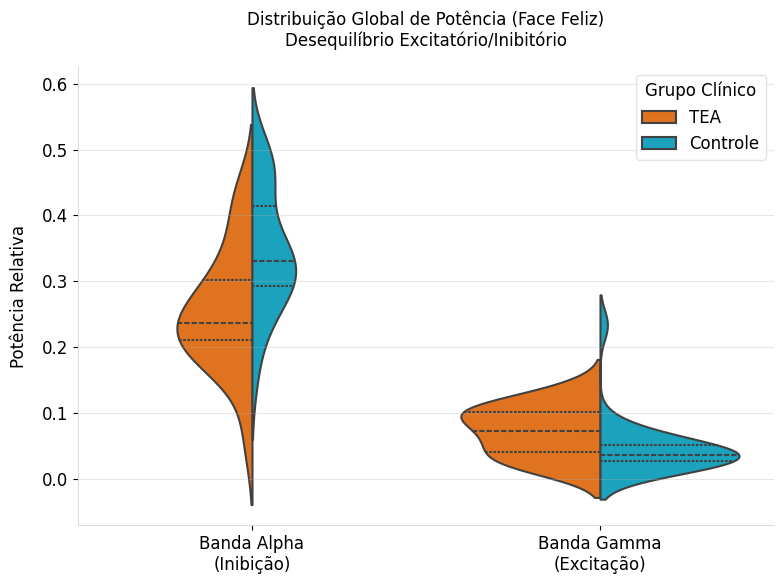

✅ Violin Plot gerado e salvo em: ../reports/figures/fig07_violinos_biomarcadores.png


In [16]:
# 05. VISUALIZAÇÃO: VIOLIN PLOT (ALPHA E GAMMA)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings

warnings.filterwarnings("ignore")

print("⏳ Estruturando distribuições biológicas brutas (Violin Plots)...")

plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 12,
    'axes.labelsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'font.weight': 'normal',
    'axes.labelweight': 'normal',
    'axes.titleweight': 'normal',
    'figure.facecolor': 'white',
    'axes.facecolor': 'white'
})

caminho_csv = '../reports/tabela_features_eeg_completa.csv'
df = pd.read_csv(caminho_csv)

df_f = df[df['Condicao'] == 'Face Feliz'].copy()
df_f = df_f.groupby(['ID', 'Grupo']).mean(numeric_only=True).reset_index()

# 1. Calculando a Média Global (Cérebro Inteiro) para Alpha e Gamma
colunas_alpha = [c for c in df_f.columns if 'AlphaRel' in c]
colunas_gamma = [c for c in df_f.columns if 'GammaRel' in c]

df_f['Alpha_Global'] = df_f[colunas_alpha].mean(axis=1)
df_f['Gamma_Global'] = df_f[colunas_gamma].mean(axis=1)

# 2. Reorganizando os dados (Melt) para o Seaborn entender a divisão
df_plot = df_f[['Grupo', 'Alpha_Global', 'Gamma_Global']].copy()
# Padronizando o nome dos grupos para a legenda
df_plot['Grupo'] = df_plot['Grupo'].apply(lambda x: 'TEA' if 'TEA' in x else 'Controle')

df_melt = pd.melt(df_plot, id_vars=['Grupo'], value_vars=['Alpha_Global', 'Gamma_Global'],
                  var_name='Banda', value_name='Potência Relativa (Média Global)')

# Traduzindo os nomes das bandas para o eixo
df_melt['Banda'] = df_melt['Banda'].replace({'Alpha_Global': 'Banda Alpha\n(Inibição)', 
                                             'Gamma_Global': 'Banda Gamma\n(Excitação)'})

# 3. Plotagem do Violino
fig, ax = plt.subplots(figsize=(8, 6))

# Paleta
paleta = {
    'Controle': '#00B4D8',   # Turquesa vibrante
    'TEA': '#FF6F00'         # Laranja forte
}

# O split=True cola as metades dos violinos
sns.violinplot(data=df_melt, x='Banda', y='Potência Relativa (Média Global)', hue='Grupo',
               split=True, inner="quartile", palette=paleta, linewidth=1.5, ax=ax)

ax.set_title("Distribuição Global de Potência (Face Feliz)\nDesequilíbrio Excitatório/Inibitório", pad=15)
ax.set_xlabel('')
ax.set_ylabel('Potência Relativa', labelpad=10)

ax.grid(axis='y', linestyle='-', alpha=0.3, color='#B0B0B0')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('#DDDDDD')
ax.spines['bottom'].set_color('#DDDDDD')

# Ajusta a legenda
plt.legend(title='Grupo Clínico', loc='upper right', frameon=True, edgecolor='#DDDDDD')
plt.tight_layout()

os.makedirs('../reports/figures', exist_ok=True)
caminho_violino = '../reports/figures/fig07_violinos_biomarcadores.png'
plt.savefig(caminho_violino, dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ Violin Plot gerado e salvo em: {caminho_violino}")